In [3]:
# import the packages used for analysis
import nltk
import pandas as pd
import numpy as np
import string
import regex as re

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_extraction, model_selection, metrics, svm

In [4]:
import datetime
import spacy
import math

In [5]:
data = pd.read_csv('Financials_and_Services.csv')      # reading data

In [6]:
data.head(5)

,Unnamed: 0,Time,Title,SubTitle,Declined Offer,Neutral Experience,Average Interview,Application,Interview,InterviewQuestions,date
0,1,"Apr 25, 2022",Senior Risk Manager Interview,Anonymous Employee,good,bad,bad,I interviewed at Citi,"multi level interviews, done over zoom, with m...",Describe a difficult scenario you encountered ...,2022-04-25
1,2,"Apr 25, 2022",Graduate Analyst Interview,"Anonymous Employee in London, England",good,good,neutral,I applied online. I interviewed at Citi (Londo...,remote interview with no technical question. G...,Name a time you were project leader ?,2022-04-25
2,3,"Apr 24, 2022",Investment Banking Associate Interview,"Anonymous Interview Candidate in New York, NY",bad,good,neutral,I applied online. I interviewed at Citi (New Y...,1. Phone interview\n2. Interview\n - Two MDs i...,- Specific questions about my research\n - Wha...,2022-04-24
3,4,"Apr 23, 2022",VP-IT Interview,Anonymous Interview Candidate in Chennai,bad,neutral,neutral,I applied online. I interviewed at Citi (Chenn...,One round with 2 VPs and they never gave prope...,Project development management agile release m...,2022-04-23
4,5,"Apr 22, 2022",Analyst Interview,"Anonymous Interview Candidate in O Fallon, MO",bad,good,bad,I applied online. I interviewed at Citi (O Fal...,The interview was as Zoom meeting. There were ...,They asked me why I was the best candidate for...,2022-04-22


In [7]:
data['combined'] = data['Interview'] + ' ' +  data['InterviewQuestions']
data.iloc[0].combined

'multi level interviews, done over zoom, with many teams involved. Behavior interview questions, focused on how I approached scenarios. Focused on my skill set and experiences. Friendly interviewers, good feedback given during and after. Describe a difficult scenario you encountered and how you handled it?'

In [8]:
data.loc[data.date <= '2019-12-31', 'period'] = 1
data.loc[(data.date > '2019-12-31') & (data.date <= '2020-06-30'), 'period'] = 2
data.loc[data.date > '2020-06-30', 'period'] = 3
data['period_count'] = data.groupby('period')['date'].transform(lambda a: len(set(a)))

#### Initialize data

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61945 entries, 0 to 61944
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          61945 non-null  int64  
 1   Time                61945 non-null  object 
 2   Title               61945 non-null  object 
 3   SubTitle            61945 non-null  object 
 4   Declined Offer      61945 non-null  object 
 5   Neutral Experience  61945 non-null  object 
 6   Average Interview   61945 non-null  object 
 7   Application         61945 non-null  object 
 8   Interview           61945 non-null  object 
 9   InterviewQuestions  61913 non-null  object 
 10  date                61945 non-null  object 
 11  combined            61913 non-null  object 
 12  period              61945 non-null  float64
 13  period_count        61945 non-null  int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 6.6+ MB


array([[<AxesSubplot:title={'center':'bad'}>,
        <AxesSubplot:title={'center':'good'}>],
       [<AxesSubplot:title={'center':'neutral'}>, <AxesSubplot:>]],
      dtype=object)

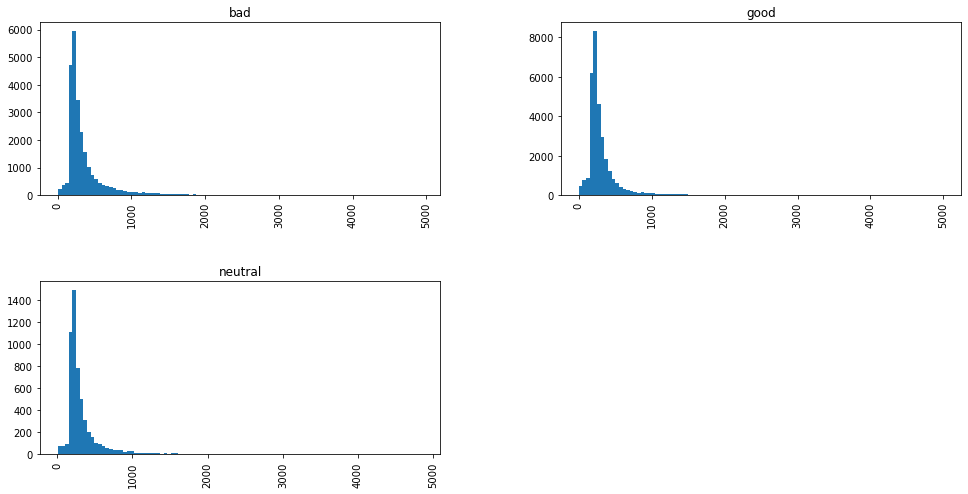

In [10]:
data['length'] = data['Interview'].apply(len)
data.hist(column='length',by='Declined Offer',bins=100, figsize=(16,8))

In [11]:
# Checking null/missing values
data.isnull().sum()

Unnamed: 0             0
Time                   0
Title                  0
SubTitle               0
Declined Offer         0
Neutral Experience     0
Average Interview      0
Application            0
Interview              0
InterviewQuestions    32
date                   0
combined              32
period                 0
period_count           0
length                 0
dtype: int64

In [12]:
data.InterviewQuestions

0        Describe a difficult scenario you encountered ...
1                    Name a time you were project leader ?
2        - Specific questions about my research\n - Wha...
3        Project development management agile release m...
4        They asked me why I was the best candidate for...
                               ...                        
61940    What is the largest sale you have been involve...
61941    Case Study: Analyze the current state of the h...
61942    Do you think cloud computing will live up to t...
61943        Describe a time when you failed at something.
61944              Why did you choose your degree subject?
Name: InterviewQuestions, Length: 61945, dtype: object

In [13]:
data = data.fillna("")
data

,Unnamed: 0,Time,Title,SubTitle,Declined Offer,Neutral Experience,Average Interview,Application,Interview,InterviewQuestions,date,combined,period,period_count,length
0,1,"Apr 25, 2022",Senior Risk Manager Interview,Anonymous Employee,good,bad,bad,I interviewed at Citi,"multi level interviews, done over zoom, with m...",Describe a difficult scenario you encountered ...,2022-04-25,"multi level interviews, done over zoom, with m...",3.0,664,236
1,2,"Apr 25, 2022",Graduate Analyst Interview,"Anonymous Employee in London, England",good,good,neutral,I applied online. I interviewed at Citi (Londo...,remote interview with no technical question. G...,Name a time you were project leader ?,2022-04-25,remote interview with no technical question. G...,3.0,664,210
2,3,"Apr 24, 2022",Investment Banking Associate Interview,"Anonymous Interview Candidate in New York, NY",bad,good,neutral,I applied online. I interviewed at Citi (New Y...,1. Phone interview\n2. Interview\n - Two MDs i...,- Specific questions about my research\n - Wha...,2022-04-24,1. Phone interview\n2. Interview\n - Two MDs i...,3.0,664,188
3,4,"Apr 23, 2022",VP-IT Interview,Anonymous Interview Candidate in Chennai,bad,neutral,neutral,I applied online. I interviewed at Citi (Chenn...,One round with 2 VPs and they never gave prope...,Project development management agile release m...,2022-04-23,One round with 2 VPs and they never gave prope...,3.0,664,164
4,5,"Apr 22, 2022",Analyst Interview,"Anonymous Interview Candidate in O Fallon, MO",bad,good,bad,I applied online. I interviewed at Citi (O Fal...,The interview was as Zoom meeting. There were ...,They asked me why I was the best candidate for...,2022-04-22,The interview was as Zoom meeting. There were ...,3.0,664,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61940,21354,"Feb 23, 2011",Sales Coordinator Interview,Anonymous Interview Candidate in MISSING VALUE,bad,neutral,neutral,I applied online. The process took 4 weeks. I ...,Contacted for initial phone interview. Took th...,What is the largest sale you have been involve...,2011-02-23,Contacted for initial phone interview. Took th...,1.0,3773,501
61941,21355,"Feb 21, 2011",Management Consulting Analyst Interview,"Anonymous Interview Candidate in New York, NY",neutral,bad,good,I applied through an employee referral The pro...,"Overall, the process was well run, however I w...",Case Study: Analyze the current state of the h...,2011-02-21,"Overall, the process was well run, however I w...",1.0,3773,87
61942,21356,"Feb 18, 2011",Manager Interview,"Anonymous Employee in Los Angeles, CA",good,neutral,good,I applied through an employee referral The pro...,This was much more informal than you'd expect....,Do you think cloud computing will live up to t...,2011-02-18,This was much more informal than you'd expect....,1.0,3773,318
61943,21357,"Feb 17, 2011",Financial Analyst Interview,"Anonymous Interview Candidate in Reston, VA",bad,neutral,neutral,I applied online. The process took 3 weeks. I ...,I first had a phone screening with a recruiter...,Describe a time when you failed at something.,2011-02-17,I first had a phone screening with a recruiter...,1.0,3773,344


In fact, the two texts in this experiment were not exactly equal; their ratio was 2:1. But this is the case where I've combined two data sources, and I think that's enough.

#### Preprocess data

In [14]:
# Removing Punctutaion
def clean1(text):
    words = []
    for word in text:
        if word not in string.punctuation:
            words.append(word)
    output= "".join(words)
    return output

In [15]:
# Tokenizing
def clean3(text):
    split=re.split("\W+",text) 
    return split

In [16]:
# Removing Stopwords
stopword = set(stopwords.words('english'))
stopword.add('interview')
stopword.add('question')
stopword.add('the')
stopword.add('i')
stopword.add('recruiter')
def clean2(text):
    return " ".join([word for word in str(text).split() if word not in stopword])

In [17]:
# Tokenizing
def clean3(text):
    split=re.split("\W+",text) 
    return split

In [18]:
# Lemmatizing
'''In order to avoid that the different parts of speech of the 
same word will disturb our analysis, we need to restore their form.'''
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text])

In [19]:
data["combined"][0]

'multi level interviews, done over zoom, with many teams involved. Behavior interview questions, focused on how I approached scenarios. Focused on my skill set and experiences. Friendly interviewers, good feedback given during and after. Describe a difficult scenario you encountered and how you handled it?'

In [20]:
combined1 = data[data["period"] == 1]["combined"]
combined2 = data[data["period"] == 2]["combined"]
combined3 = data[data["period"] == 3]["combined"]

In [21]:
data[data["period"] == 1]["period_count"]

1630     3773
1631     3773
1632     3773
1633     3773
1634     3773
         ... 
61940    3773
61941    3773
61942    3773
61943    3773
61944    3773
Name: period_count, Length: 43027, dtype: int64

In [22]:
data[data["period"] == 2]["period_count"]

1454     182
1455     182
1456     182
1457     182
1458     182
        ... 
49054    182
49055    182
49056    182
49057    182
49058    182
Name: period_count, Length: 1616, dtype: int64

In [23]:
data[data["period"] == 3]["period_count"]

0        664
1        664
2        664
3        664
4        664
        ... 
48399    664
48400    664
48401    664
48402    664
48403    664
Name: period_count, Length: 17302, dtype: int64

In [24]:
period1count=3773
period2count=182
period3count=664

In [25]:
def dataprocessing(target):
    target = target.apply(lambda x: clean1(x))
    target = target.apply(lambda x: clean3(x))
    target = target.apply(lambda x: clean2(x))
    target = target.apply(lambda x: clean3(x))
    target = target.apply(lambda text: lemmatize_words(text))
    output = " ".join(target.tolist())
    return output

In [26]:
period1combined = dataprocessing(combined1)
period2combined = dataprocessing(combined2)
period3combined = dataprocessing(combined3)

In [27]:
# Finding most repeated words in the data
def top_words(text,words,count):
    allWords = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = set(stopwords)
    appendlist = {"the","i",'interviewer',"interview","wa","recruiter","process","question","one","would","1",'2','3','4','5','6','asked','got','hr'}
    stopwords.update(appendlist)
    allWordExceptStopDist = nltk.FreqDist([w.lower() for w in allWords if w.lower() not in list(stopwords)])   
    mostCommontuples= allWordExceptStopDist.most_common(words)
    mostCommon = [(tupl[0],round(tupl[1]/count,2)) for tupl in mostCommontuples]
    return mostCommon

#### High frequency words for different kinds of situations

In [28]:
type1p1 = top_words(period1combined,100,period1count)

In [29]:
type1p2 = top_words(period2combined,100,period2count)

In [30]:
type1p3 = top_words(period2combined,100,period3count)

In [31]:
def foundchange(list1,list2):
    output = {}
    for word1 in list1:
        for word2 in list2:
            if word1[0] == word2[0]:
                percentchange = round(word2[1]/word1[1] - 1,2)
                if percentchange >= 0.2 or percentchange <= -0.4:
                    output[word1[0]] = percentchange
    return output

In [32]:
def standard(lst,aimdic):
    output = {}
    total = []
    for word in aimdic.keys():
        for word1 in lst:
            if word1[0] == word:
                total.append(word1[1])
    average = sum(total) / len(total)
    for word in aimdic.keys():
        for word1 in lst:
            if word1[0] == word:
                output[word] = round(word1[1]/average,2)
    return output

In [33]:
def foundchangeforp2to3(aimdic2,aimdic3):
    output = {}
    for word2 in aimdic2.keys():
        for word3 in aimdic3.keys():
            if word2 == word3:
                output[word2] = round((aimdic3[word2])/(aimdic2[word2])-1,2)
    return output

In [34]:
change1 = foundchange(type1p1,type1p2)
print(change1)

{'phone': -0.46, 'manager': -0.51, 'week': -0.58, 'two': -0.4, 'job': -0.48, 'work': -0.41, 'position': -0.57, 'applied': -0.41, 'group': -0.51, 'people': -0.42, 'get': -0.4, 'later': -0.57, 'back': -0.48, 'minute': -0.46, 'email': -0.4, 'went': -0.53, 'received': -0.46, 'face': -0.44, 'customer': -0.63, 'hour': -0.47, 'want': -0.48, 'difficult': -0.52, 'called': -0.53, 'interviewed': -0.5, 'make': -0.44, 'background': -0.44, 'really': -0.43, 'told': -0.45, '30': -0.45, 'three': -0.47, 'take': -0.41, 'another': -0.46, 'go': -0.44, 'didnt': -0.46, 'long': -0.43, 'etc': -0.42, 'de': 1.32}


In [35]:
stand1 = standard(type1p2,foundchange(type1p1,type1p2))

In [36]:
stand2 = standard(type1p3,foundchange(type1p1,type1p2))

In [37]:
change2 = foundchangeforp2to3(standard(type1p2,foundchange(type1p1,type1p2)),standard(type1p3,foundchange(type1p1,type1p2)))

In [38]:
relatedword = ['position','group','customer','job']

In [39]:
def preplot(wordlist,changep1,changep2,intialfrequent):
    output = {}
    for word in wordlist:
        for word1 in intialfrequent:
            if word == word1[0]:
                initial = word1[1]
                p2 = round(initial * (changep1[word]+1),2)
                p3 = round(p2 * (changep2[word]+1),2)
                output[word] = [initial, p2, p3]
    return output

In [40]:
preplot(relatedword,change1,change2,type1p1)

{'position': [2.14, 0.92, 0.92],
 'group': [1.86, 0.91, 0.91],
 'customer': [1.3, 0.48, 0.47],
 'job': [2.46, 1.28, 1.28]}

In [41]:
period = ["before 2019-12-31","2019-12-31 to 2020-06-30", "after 2020-06-30"]

In [42]:
def plot(preplot,period):
    for word,change in preplot.items():
        plt.plot(period,change,label=word)
    plt.title('Word changes')
    plt.xlabel('period')
    plt.ylabel('frequency/day')
    plt.legend()

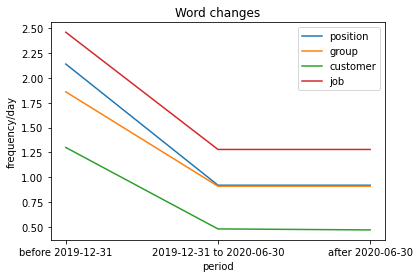

In [43]:
plot(preplot(relatedword,change1,change2,type1p1),period)